# MeterGroup, ElecMeter, selection and basic statistics

All NILM datasets consists of various groupings of electricity meters.  We can group the meters by house.  Or by the type of appliance they are directly connected to.  Or by sample rate.  Or by whether the meter is a whole-house "site meter" or an appliance-level submeter, or a circuit-level submeter.

In NILMTK, one of the key classes is `MeterGroup` which stores a list of `meters` and allows us to select a subset of meters, aggregate power from all meters and many other functions.

When we first open a `DataSet`, NILMTK creates several `MeterGroup` objects.  There's `nilmtk.global_meter_group` which holds every meter currently loaded (including from multiple datasets if you have opened more than one dataset).  There is also one `MeterGroup` per building (which live in the `Building.elec` attribute).  We also nested `MeterGroups` for aggregating together split-phase mains, 3-phase mains and dual-supply (240 volt) appliances in North American and Canadan datasets.  For example, here is the `MeterGroup` for building 1 in REDD:

**NOTE**: If you are on Windows, remember to escape the back-slashes, use forward-slashs, or use raw-strings when passing paths in Python, e.g. one of the following would work:

```python
redd = DataSet('c:\\data\\REDD\\redd.h5')
redd = DataSet('c:/data/REDD/redd.h5')
redd = DataSet(r'c:\data\REDD\redd.h5')
```

In [4]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
rcParams['figure.figsize'] = (13, 10)
plt.style.use('ggplot')
import nilmtk
from nilmtk import DataSet, MeterGroup


redd = DataSet('/data/REDD/redd.h5')
elec = redd.buildings[1].elec
elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric 

Note that there are two nested `MeterGroups`: one for the electric oven, and one for the washer dryer (both of which are 240 volt appliances and have two meters per appliance):

In [5]:
elec.nested_metergroups()

[MeterGroup(meters=
   ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
   ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
 ), MeterGroup(meters=
   ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
   ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
 )]

Putting these meters into a `MeterGroup` allows us to easily sum together the power demand recorded by both meters to get the total power demand for the entire appliance (but it's also very easy to see the individual meter power demand too).

We can easily get a MeterGroup of either the submeters or the mains:

In [6]:
elec.mains()

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REDD', site_meter, appliances=[])
)

We can easily get the power data for both mains meters summed together:

In [7]:
elec.mains().power_series_all_data().head()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


2011-04-18 09:22:09-04:00    342.820007
2011-04-18 09:22:10-04:00    344.559998
2011-04-18 09:22:11-04:00    345.140015
2011-04-18 09:22:12-04:00    341.679993
2011-04-18 09:22:13-04:00    341.029999
Name: (power, apparent), dtype: float32

In [8]:
elec.submeters()

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=14, building=1, dataset='REDD', appliances=[Appliance(type='electric stove', instance=1)])
  ElecMeter(insta

## Stats for MeterGroups

### Proportion of energy submetered

Let's work out the proportion of energy submetered in REDD building 1:

In [10]:
elec.proportion_of_energy_submetered()

Running MeterGroup.proportion_of_energy_submetered...
Calculating total_energy for ElecMeterID(instance=2, building=1, dataset='REDD') ...   

0.7599031850888346

Note that NILMTK has raised a warning that Mains uses a different type of power measurement than all the submeters, so it's not an entirely accurate comparison.  Which raises the question: which type of power measurements are used for the mains and submeters?  Let's find out...

### Active, apparent and reactive power

In [11]:
mains = elec.mains()

In [12]:
mains.available_ac_types('power')

['apparent']

In [13]:
elec.submeters().available_ac_types('power')

['active']

In [14]:
list(elec.load())

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')      dataset='REDD'), ElecMeterID(instance=4, building=1, dataset='REDD')))     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')      dataset='REDD'), ElecMeterID(instance=20, building=1, dataset='REDD')))     
Done loading data all meters for this chunk.

Done loading data all meters for this chunk.


[physical_quantity               power       
 type                         apparent active
 2011-04-18 09:22:09-04:00  344.173340    NaN
 2011-04-18 09:22:12-04:00  341.170013  261.0
 2011-04-18 09:22:15-04:00  341.973328  261.0
 2011-04-18 09:22:18-04:00  341.683319  262.0
 2011-04-18 09:22:21-04:00  341.796661  262.0
 2011-04-18 09:22:24-04:00  341.330017  261.0
 2011-04-18 09:22:27-04:00  341.223328  261.0
 2011-04-18 09:22:30-04:00  341.250000  260.0
 2011-04-18 09:22:33-04:00  341.503326  260.0
 2011-04-18 09:22:36-04:00  342.196655  262.0
 2011-04-18 09:22:39-04:00  345.356689  266.0
 2011-04-18 09:22:42-04:00  342.736664  260.0
 2011-04-18 09:22:45-04:00  342.610016  261.0
 2011-04-18 09:22:48-04:00  342.683350  261.0
 2011-04-18 09:22:51-04:00  344.553345  267.0
 2011-04-18 09:22:54-04:00  341.613342  262.0
 2011-04-18 09:22:57-04:00  344.770020  264.0
 2011-04-18 09:23:00-04:00  345.350006  267.0
 2011-04-18 09:23:03-04:00  344.976654  266.0
 2011-04-18 09:23:06-04:00  343.89

### Total Energy

In [15]:
elec.mains().total_energy() # returns kWh

Calculating total_energy for ElecMeterID(instance=2, building=1, dataset='REDD') ...   

apparent    167.766283
dtype: float64

### Energy per submeter

In [16]:
energy_per_meter = elec.submeters().energy_per_meter() # kWh, again
energy_per_meter

15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

,"(5, 1, REDD)","(6, 1, REDD)","(7, 1, REDD)","(8, 1, REDD)","(9, 1, REDD)","(11, 1, REDD)","(12, 1, REDD)","(13, 1, REDD)","(14, 1, REDD)","(15, 1, REDD)","(16, 1, REDD)","(17, 1, REDD)","(18, 1, REDD)","(19, 1, REDD)","(((3, 1, REDD), (4, 1, REDD)),)","(((10, 1, REDD), (20, 1, REDD)),)"
active,44.750925,19.920875,16.786282,22.939649,30.734511,16.890262,5.221226,0.096302,0.411592,4.507334,2.256583,18.288595,11.811224,0.000085,8.81796,32.614809
apparent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


column headings are the ElecMeter instance numbers.

The function `fraction_per_meter` does the same thing as `energy_per_submeter` but returns the fraction of energy per meter.

### Select meters on the basis of their energy consumption

Let's make a new MeterGroup which only contains the ElecMeters which used more than 20 kWh:

In [17]:
# energy_per_meter is a DataFrame where each row is a 
# power type ('active', 'reactive' or 'apparent').
# All appliance meters in REDD are record 'active' so just select
# the 'active' row:
energy_per_meter = energy_per_meter.loc['active']
more_than_20 = energy_per_meter[energy_per_meter > 20]
more_than_20

(5, 1, REDD)                         44.750925
(8, 1, REDD)                         22.939649
(9, 1, REDD)                         30.734511
(((10, 1, REDD), (20, 1, REDD)),)    32.614809
Name: active, dtype: float64

In [18]:
instances = more_than_20.index
instances

Index([                       (5, 1, 'REDD'),
                              (8, 1, 'REDD'),
                              (9, 1, 'REDD'),
       (((10, 1, 'REDD'), (20, 1, 'REDD')),)],
      dtype='object')

## Plot fraction of energy consumption of each appliance

In [19]:
fraction = elec.submeters().fraction_per_meter().dropna()

15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

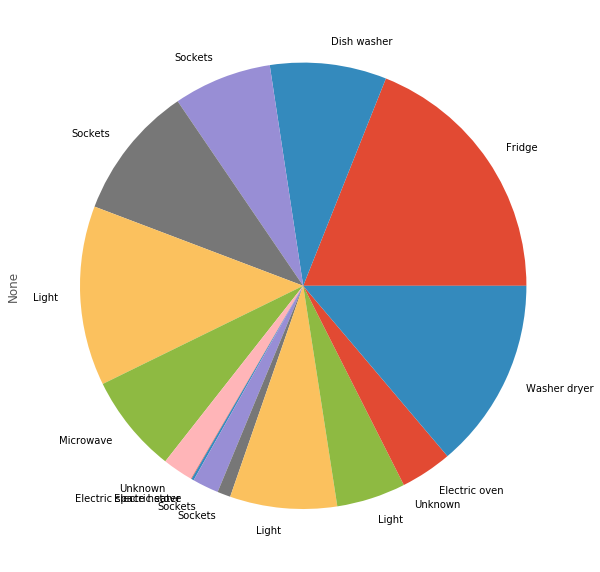

In [20]:
# Create convenient labels
labels = elec.get_labels(fraction.index)
plt.figure(figsize=(10,30))
fraction.plot(kind='pie', labels=labels);

### Draw wiring diagram

We can get the wiring diagram for the MeterGroup:

(<networkx.classes.digraph.DiGraph at 0x7faaf67a2da0>,
 <matplotlib.axes._axes.Axes at 0x7faaf67a2f60>)

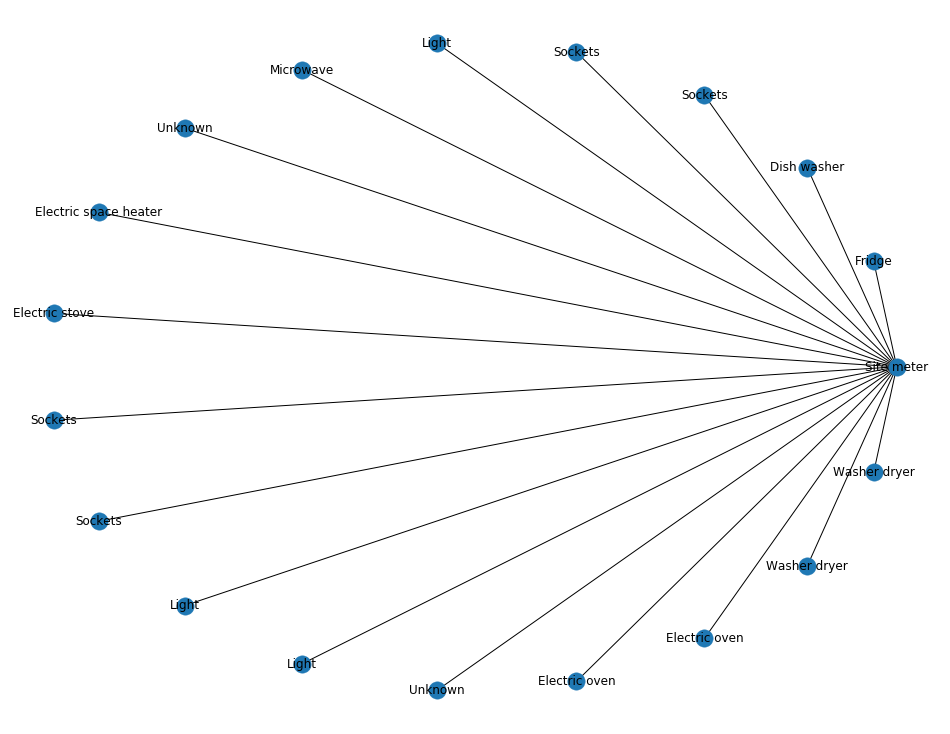

In [22]:
elec.draw_wiring_graph()

It's not very pretty but it shows that meters (1,2) (the site meters) are upstream of all other meters.

Buildings in REDD have only two levels in their meter hierarchy (mains and submeters).  If there were more than two levels then it might be useful to get only the meters immediately downstream of mains:

In [23]:
elec.meters_directly_downstream_of_mains()

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=14, building=1, dataset='REDD', appliances=[Appliance(type='electric stove', instance=1)])
  ElecMeter(insta

### Plot appliances when they are in use 

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


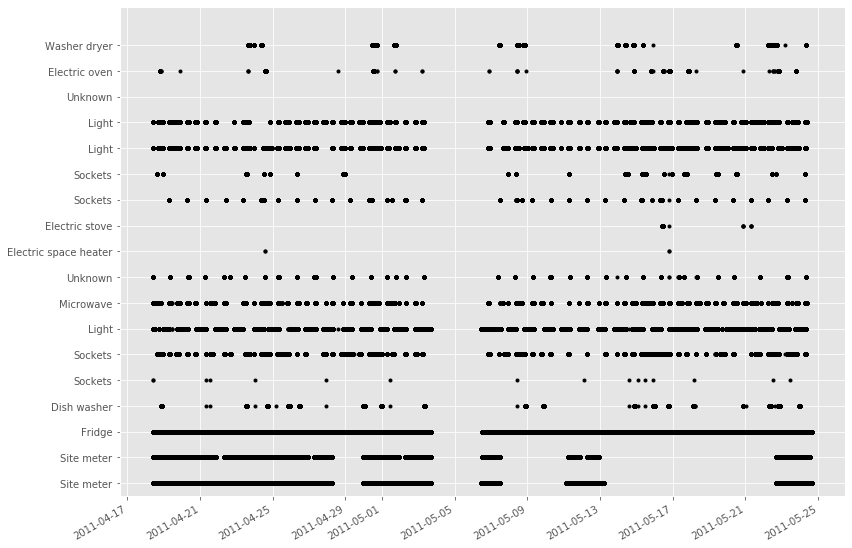

In [24]:
sns.set_palette("Set3", n_colors=12)
# Set a threshold to remove residual power noise when devices are off
elec.plot_when_on(on_power_threshold = 40)

## Stats and info for individual meters

The `ElecMeter` class represents a single electricity meter.  Each `ElecMeter` has a list of associated `Appliance` objects.  `ElecMeter` has many of the same stats methods as `MeterGroup` such as `total_energy` and `available_power_ac_types` and `power_series` and `power_series_all_data`.  We will now explore some more stats functions (many of which are also available on `MeterGroup`)...

In [25]:
fridge_meter = elec['fridge']

### Get upstream meter

In [26]:
fridge_meter.upstream_meter() # happens to be the mains meter group!

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REDD', site_meter, appliances=[])
)

### Metadata about the class of meter

In [27]:
fridge_meter.device

{'model': 'eMonitor',
 'manufacturer': 'Powerhouse Dynamics',
 'manufacturer_url': 'http://powerhousedynamics.com',
 'description': 'Measures circuit-level power demand.  Comes with 24 CTs. This FAQ page suggests the eMonitor measures real (active) power: http://www.energycircle.com/node/14103  although the REDD readme.txt says all channels record apparent power.\n',
 'sample_period': 3,
 'max_sample_period': 50,
 'measurements': [{'physical_quantity': 'power',
   'type': 'active',
   'upper_limit': 5000,
   'lower_limit': 0}],
 'wireless': False}

### Dominant appliance

If the metadata specifies that a meter has multiple meters connected to it then one of those can be specified as the 'dominant' appliance, and this appliance can be retrieved with this method:

In [28]:
fridge_meter.dominant_appliance()

Appliance(type='fridge', instance=1)

### Total energy

In [29]:
fridge_meter.total_energy() # kWh

active    44.750925
dtype: float64

### Get good sections

If we plot the raw power data then we see there is one large gap where, supposedly, the metering system was not working.  (if we were to zoom in then we'd see lots of smaller gaps too):

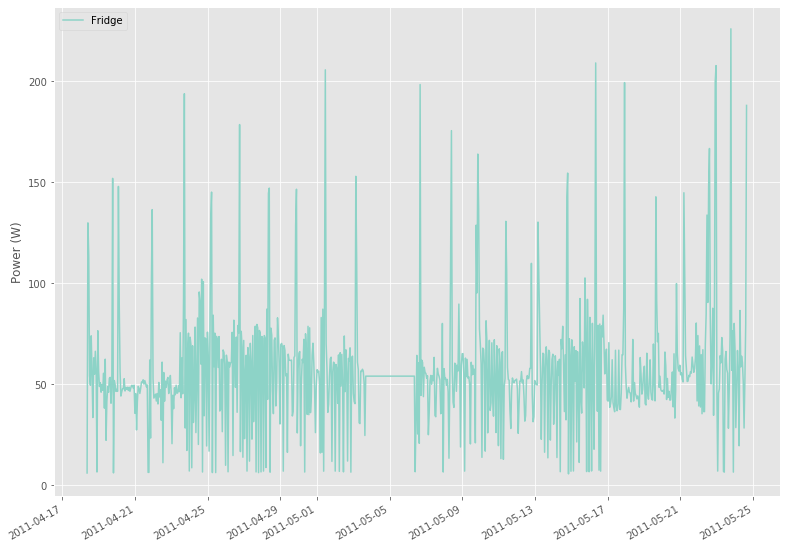

In [30]:
fridge_meter.plot()

We can automatically identify the 'good sections' (i.e. the sections where every pair of consecutive samples is less than `max_sample_period` specified in the dataset metadata):

In [34]:
good_sections = fridge_meter.good_sections(full_results=True)
# specifying full_results=False would give us a simple list of 
# TimeFrames.  But we want the full GoodSectionsResults object so we can
# plot the good sections...

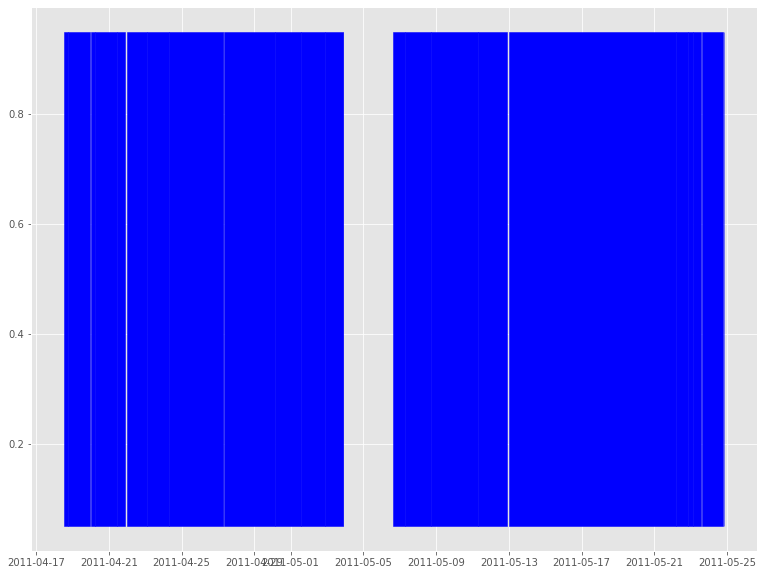

In [35]:
good_sections.plot()

The blue chunks show where the data is good.  The white gap is the large gap seen in the raw power data.  There are lots of smaller gaps that we cannot see at this zoom level.

We can also see the exact sections identified:

In [36]:
good_sections.combined()

[TimeFrame(start='2011-04-18 09:22:13-04:00', end='2011-04-18 14:00:33-04:00', empty=False),
 TimeFrame(start='2011-04-18 14:03:11-04:00', end='2011-04-19 18:45:09-04:00', empty=False),
 TimeFrame(start='2011-04-19 20:20:05-04:00', end='2011-04-20 01:54:26-04:00', empty=False),
 TimeFrame(start='2011-04-20 01:55:33-04:00', end='2011-04-21 06:14:43-04:00', empty=False),
 TimeFrame(start='2011-04-21 06:17:22-04:00', end='2011-04-21 17:45:02-04:00', empty=False),
 TimeFrame(start='2011-04-21 19:41:23-04:00', end='2011-04-22 22:46:53-04:00', empty=False),
 TimeFrame(start='2011-04-22 22:48:31-04:00', end='2011-04-24 03:48:44-04:00', empty=False),
 TimeFrame(start='2011-04-24 03:52:28-04:00', end='2011-04-27 02:50:14-04:00', empty=False),
 TimeFrame(start='2011-04-27 02:51:25-04:00', end='2011-04-27 03:17:31-04:00', empty=False),
 TimeFrame(start='2011-04-27 03:21:19-04:00', end='2011-04-29 23:07:52-04:00', empty=False),
 TimeFrame(start='2011-04-29 23:10:38-04:00', end='2011-05-01 09:44:36

### Dropout rate

As well as large gaps appearing because the entire system is down, we also get frequent small gaps from wireless sensors dropping data.  This is sometimes called 'dropout'.  The dropout rate is a number between 0 and 1 which specifies the proportion of missing samples.  A dropout rate of 0 means no samples are missing.  A value of 1 would mean all samples are missing:

In [37]:
fridge_meter.dropout_rate()

0.21922786156570626

Note that the dropout rate has gone down (which is good!) now that we are ignoring the gaps.  This value is probably more representative of the performance of the wireless system.

## Select subgroups of meters

We use `ElecMeter.select_using_appliances()` to select a new MeterGroup using an metadata field.  For example, to get all the washer dryers in the whole of the REDD dataset:

In [38]:
import nilmtk
nilmtk.global_meter_group.select_using_appliances(type='washer dryer')

MeterGroup(meters=
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=7, building=2, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=7, building=4, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=8, building=5, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=9, building=5, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=4, building=6, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1

Or select multiple appliance types:

In [28]:
elec.select_using_appliances(type=['fridge', 'microwave'])

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
)

Or all appliances in the 'heating' category:

In [39]:
nilmtk.global_meter_group.select_using_appliances(category='heating')

MeterGroup(meters=
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=10, building=3, dataset='REDD', appliances=[Appliance(type='electric furnace', instance=1)])
  ElecMeter(instance=4, building=4, dataset='REDD', appliances=[Appliance(type='electric furnace', instance=1)])
  ElecMeter(instance=6, building=5, dataset='REDD', appliances=[Appliance(type='electric furnace', instance=1)])
  ElecMeter(instance=12, building=5, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=13, building=5, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=12, building=6, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
)

Or all appliances in building 1 with a single-phase induction motor(!):

In [40]:
nilmtk.global_meter_group.select_using_appliances(building=1, category='single-phase induction motor')

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
)

(NILMTK imports the 'common metadata' from the NILM Metadata project, which includes a wide range of different [category taxonomies](http://nilm-metadata.readthedocs.org/en/latest/central_metadata.html#appliancetype))

In [41]:
nilmtk.global_meter_group.select_using_appliances(building=2, category='laundry appliances')

MeterGroup(meters=
  ElecMeter(instance=7, building=2, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=11, building=2, dataset='REDD', appliances=[Appliance(type='waste disposal unit', instance=1)])
)

### Select a group of meters from properties of the meters (not the appliances)

In [42]:
elec.select(device_model='REDD_whole_house')

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REDD', site_meter, appliances=[])
)

In [43]:
elec.select(sample_period=3)

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=14, building=1, dataset='REDD', appliances=[Appliance(type='electric stove', instance=1)])
  ElecMeter(insta

## Select a single meter from a MeterGroup

We use `[]` to retrive a single `ElecMeter` from a `MeterGroup`.

### Search for a meter using appliances connected to each meter

In [44]:
elec['fridge']

ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])

Appliances are uniquely identified within a building by a `type` (fridge, kettle, television, etc.) and an `instance` number.  If we do not specify an instance number then `ElecMeter` retrieves instance 1 (instance numbering starts from 1).  If you want a different instance then just do this:

In [45]:
elec['light', 2]

ElecMeter(instance=17, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=2)])

To uniquely identify an appliance in `nilmtk.global_meter_group` then we must specify the dataset name, building instance number, appliance type and appliance instance in a dict:

In [46]:
import nilmtk
nilmtk.global_meter_group[{'dataset': 'REDD', 'building': 1, 'type': 'fridge', 'instance': 1}]

ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])

### Search for a meter using details of the ElecMeter

get ElecMeter with instance = 1:

In [47]:
elec[1]

ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])

### Instance numbering

ElecMeter and Appliance instance numbers uniquely identify the meter or appliance type within the *building*, not globally.  To uniquely identify a meter globally, we need three keys:

In [48]:
from nilmtk.elecmeter import ElecMeterID 
# ElecMeterID is a namedtuple for uniquely identifying each ElecMeter

nilmtk.global_meter_group[ElecMeterID(instance=8, building=1, dataset='REDD')]

ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])

### Select nested MeterGroup

We can also select a single, existing nested MeterGroup.  There are two ways to specify a nested MeterGroup:

In [49]:
elec[[ElecMeterID(instance=3, building=1, dataset='REDD'), 
      ElecMeterID(instance=4, building=1, dataset='REDD')]]

MeterGroup(meters=
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
)

In [50]:
elec[ElecMeterID(instance=(3,4), building=1, dataset='REDD')]

MeterGroup(meters=
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
)

We can also specify the mains by asking for meter instance 0:

In [51]:
elec[ElecMeterID(instance=0, building=1, dataset='REDD')]

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REDD', site_meter, appliances=[])
)

which is equivalent to elec.mains():

In [52]:
elec.mains() == elec[ElecMeterID(instance=0, building=1, dataset='REDD')]

True

## Plot sub-metered data for a single day

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


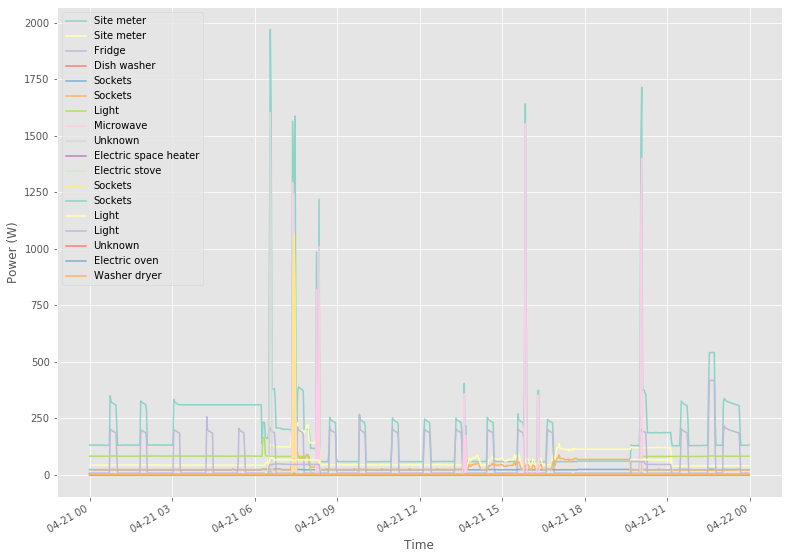

In [53]:
redd.set_window(start='2011-04-21', end='2011-04-22')
elec.plot();
plt.xlabel("Time");

## Autocorrelation Plot

In [54]:
from pandas.plotting import autocorrelation_plot

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


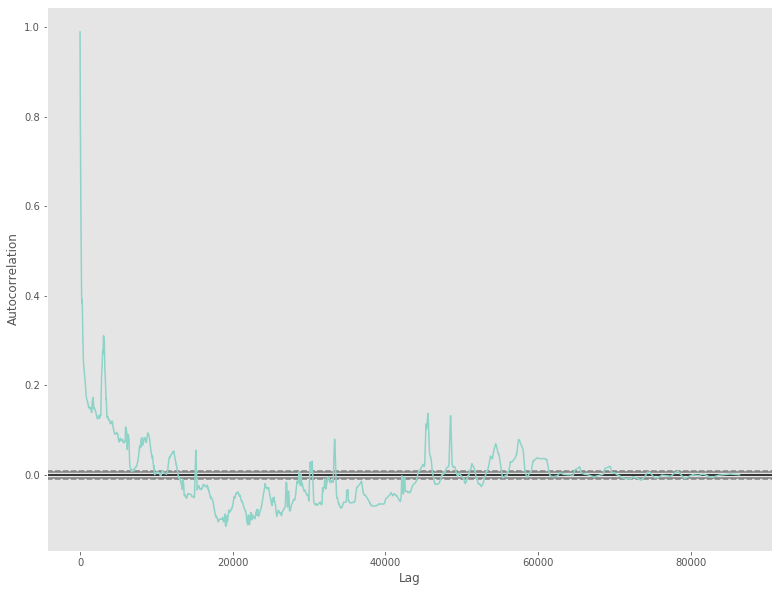

In [55]:
elec.mains().plot_autocorrelation();

## Daily energy consumption across fridges in the dataset

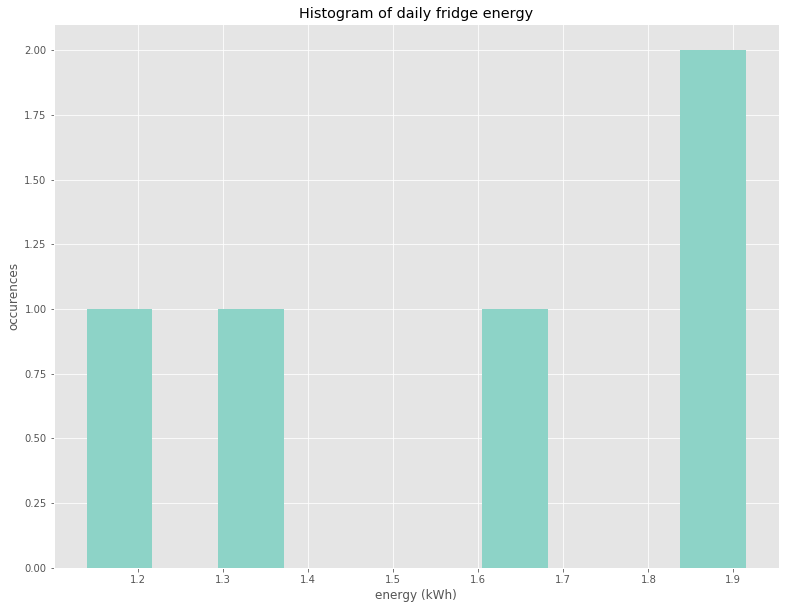

In [56]:
fridges_restricted = nilmtk.global_meter_group.select_using_appliances(type='fridge')
daily_energy = pd.DataFrame([meter.average_energy_per_period(offset_alias='D') 
                             for meter in fridges_restricted.meters])

daily_energy.plot(kind='hist');
plt.title('Histogram of daily fridge energy');
plt.xlabel('energy (kWh)');
plt.ylabel('occurences');
plt.legend().set_visible(False)

## Correlation dataframe of the appliances

In [61]:
correlation_df = elec.pairwise_correlation()
correlation_df

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chun

Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chu

,"(1, 1, REDD)","(2, 1, REDD)","(5, 1, REDD)","(6, 1, REDD)","(7, 1, REDD)","(8, 1, REDD)","(9, 1, REDD)","(11, 1, REDD)","(12, 1, REDD)","(13, 1, REDD)","(14, 1, REDD)","(15, 1, REDD)","(16, 1, REDD)","(17, 1, REDD)","(18, 1, REDD)","(19, 1, REDD)","(((3, 1, REDD), (4, 1, REDD)),)","(((10, 1, REDD), (20, 1, REDD)),)"
"(1, 1, REDD)",1,0.133881,0.377359,0.162288,-0.00471913,-0.0996323,0.329465,0.674169,0.435024,0.784056,0.831063,0.315794,0.681408,0.288833,0.283513,NaN,0.0212352,0.144032
"(2, 1, REDD)",0.133881,1,-0.0937125,-0.0359251,0.249301,0.702927,-0.0932022,0.117099,0.0877732,0.143877,0.162691,0.178104,0.221559,0.749084,0.737687,NaN,0.00256023,-0.0340499
"(5, 1, REDD)",0.377359,-0.0937125,1,0.544081,0.214719,-0.145134,0.108847,0.00518485,0.0879256,0.0613822,0.0946321,-0.0270217,0.0298573,-0.00203541,0.00180875,NaN,0.121275,0.411608
"(6, 1, REDD)",0.162288,-0.0359251,0.544081,1,0.211379,-0.0492527,0.0423541,0.0292081,-0.00568256,0.020327,0.0725096,-0.00771563,0.0112727,-0.0120231,-0.00784038,NaN,0.130844,0.558686
"(7, 1, REDD)",-0.00471913,0.249301,0.214719,0.211379,1,0.358102,-0.135737,-0.00587421,0.00151782,-0.00177207,0.00664499,-0.0170461,-0.0124059,0.0058632,0.00548738,NaN,0.0344461,0.138726
"(8, 1, REDD)",-0.0996323,0.702927,-0.145134,-0.0492527,0.358102,1,-0.352982,0.0356909,-0.0201429,0.0127344,0.027573,0.131574,0.101213,0.0626436,0.0524957,NaN,-0.0106104,-0.0446488
"(9, 1, REDD)",0.329465,-0.0932022,0.108847,0.0423541,-0.135737,-0.352982,1,-0.0484712,0.0486186,-0.00604461,0.00686124,0.052323,0.0451693,0.206243,0.187374,NaN,-0.0069217,0.0612987
"(11, 1, REDD)",0.674169,0.117099,0.00518485,0.0292081,-0.00587421,0.0356909,-0.0484712,1,0.00875737,0.748305,0.755141,0.0393549,0.37349,0.135711,0.144454,NaN,-0.00169212,0.0343062
"(12, 1, REDD)",0.435024,0.0877732,0.0879256,-0.00568256,0.00151782,-0.0201429,0.0486186,0.00875737,1,0.653199,0.62843,0.000221234,0.480808,0.147108,0.119364,NaN,-0.000819459,-0.00263386
"(13, 1, REDD)",0.784056,0.143877,0.0613822,0.020327,-0.00177207,0.0127344,-0.00604461,0.748305,0.653199,1,0.98348,0.0303775,0.607367,0.1968,0.185798,NaN,-0.00188285,0.0228828
